In [1]:
import os 
import logging
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.signal import convolve2d

# logging.getLogger().setLevel(logging.INFO)
sys.path.append('..')

In [2]:
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger('matplotlib').setLevel(logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.lippmann_schwinger_eqn.HelmholtzSolver import (
    HelmholtzSolverAccelerated,
    setup_accelerated_solver,
)


# Init Helmholtz Solver

In [5]:
N_PIXELS = 200
SPATIAL_DOMAIN_MAX = 0.5
WAVENUMBER = 16
RECEIVER_RADIUS = 100

In [6]:
solver_obj = setup_accelerated_solver(N_PIXELS, 
                                      SPATIAL_DOMAIN_MAX, 
                                      WAVENUMBER, 
                                      RECEIVER_RADIUS, 
                                      diag_correction=True)

# Define functions

In [7]:
# STENCIL = np.array([[0.25, 0.5, 0.25],
#                    [0.5, -3, 0.5],
#                    [0.25, 0.5, 0.25]])
STENCIL = np.array([[0., 1., 0],
                   [1, -4, 1],
                   [0, 1, 0]])
def check_soln_against_finite_differences(u_soln: np.ndarray,
                                         domain_points_arr: np.ndarray,
                                         scattering_obj: np.ndarray,
                                         frequency: float) -> None:
    dx = domain_points_arr[0, 1, 0] - domain_points_arr[0, 0, 0]
    
    lap_filter = STENCIL / (dx ** 2)
    
    # Returns a slightly smaller array, which only contains those pixels which 
    # have a valid convolution output without padding
    lap_u = convolve2d(u_soln, lap_filter, mode='valid') * (dx ** 2) / (frequency ** 2)

    # Compute how many pixels I need to remove from scattering_obj and u_soln
    p = int((u_soln.shape[0] - lap_u.shape[0]) / 2)
    
    inhomogeniety =  (1 - scattering_obj[p:-p, p:-p]) * u_soln[p:-p, p:-p] * (dx ** 2)
    
    err = lap_u + inhomogeniety
    return err, lap_u, inhomogeniety

# Example 1: Smooth, Low-Contrast, Decrease Wave Speed

In this example, $q(x)$ is a smooth Gaussian bump with maximum height 0.1. This corresponds to an inhomogeneous medium which slows down the incoming wave. 

In [8]:
pt_nrms = np.linalg.norm(solver_obj.domain_points_arr, axis=-1)
q_gauss = 0.1 * np.exp(-1 * np.square(pt_nrms) / 0.05)

In [9]:
q = q_gauss

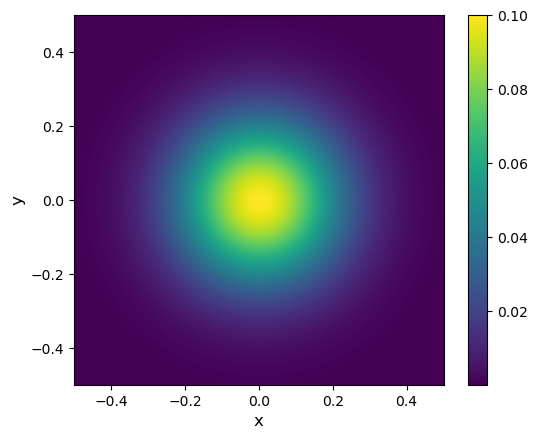

In [28]:
EXTENT = np.array([-0.5, 0.5, -0.5, 0.5])
S = 12
fig, ax = plt.subplots()

im_0 = ax.imshow(q, extent=EXTENT)
ax.set_xlabel("x", size=S)
ax.set_ylabel("y", size=S)
plt.colorbar(im_0, ax=ax)
plt.show()

In [29]:
inc_dir = np.array([0, 3 * np.pi / 4, np.pi])

soln, _, u_scat = solver_obj.Helmholtz_solve_interior(inc_dir, q)

In [30]:
soln = soln[1]
u_scat = u_scat[1]

In [31]:
errs, _, _ = check_soln_against_finite_differences(soln,
                                            solver_obj.domain_points_arr,
                                            q,
                                            solver_obj.frequency)

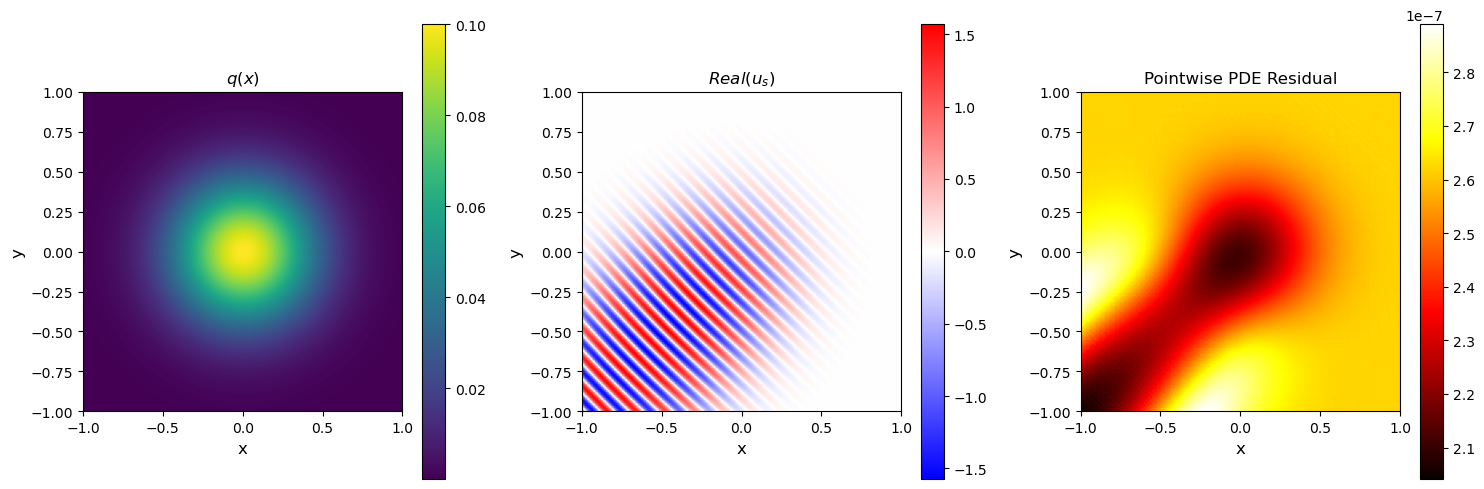

In [32]:
EXTENT = np.array([-1, 1, -1, 1])
S = 12
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

im_0 = ax[0].imshow(q, extent=EXTENT)
ax[0].set_xlabel("x", size=S)
ax[0].set_ylabel("y", size=S)
ax[0].set_title("$q(x)$", size=S)
plt.colorbar(im_0, ax=ax[0])



im_1 = ax[1].imshow(u_scat.real, extent=EXTENT, cmap='bwr')
ax[1].set_xlabel("x", size=S)
ax[1].set_ylabel("y", size=S)
ax[1].set_title("$Real(u_s)$", size=S)
plt.colorbar(im_1, ax=ax[1])

im_2 = ax[2].imshow(np.abs(errs), extent=EXTENT, cmap='hot')
ax[2].set_xlabel("x", size=S)
ax[2].set_ylabel("y", size=S)
ax[2].set_title("Pointwise PDE Residual", size=S)
plt.colorbar(im_2, ax=ax[2])

fig.tight_layout()
plt.show()

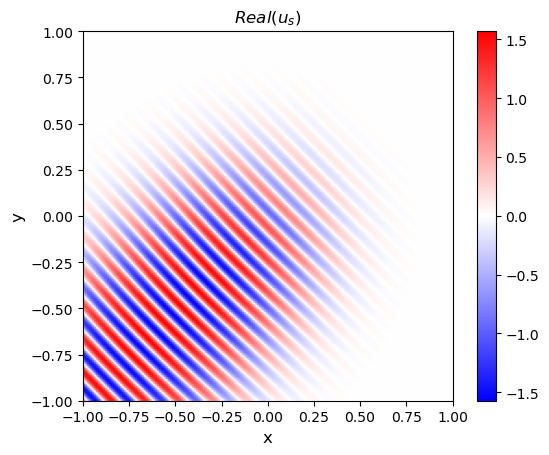

In [33]:
fig, ax = plt.subplots()

im_1 = ax.imshow(u_scat.real, extent=EXTENT, cmap='bwr')
ax.set_xlabel("x", size=S)
ax.set_ylabel("y", size=S)
ax.set_title("$Real(u_s)$", size=S)
plt.colorbar(im_1, ax=ax)
plt.show()

# Example 2: Smooth, High-Contrast, Increase Wave Speed

In this example, $q(x)$ is a smooth Gaussian bump with scaling coefficient -5. This corresponds to an inhomogeneous medium which speeds up the incoming wave. 

In [41]:
pt_nrms = np.linalg.norm(solver_obj.domain_points_arr, axis=-1)
q_gauss = -5 * np.exp(-1 * np.square(pt_nrms) / 0.05)

In [42]:
q = q_gauss

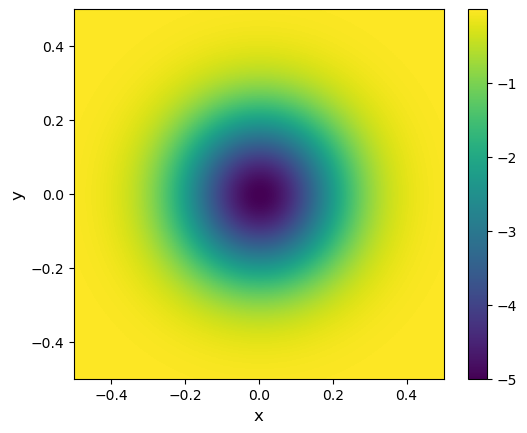

In [43]:
EXTENT = np.array([-0.5, 0.5, -0.5, 0.5])
S = 12
fig, ax = plt.subplots()

im_0 = ax.imshow(q, extent=EXTENT)
ax.set_xlabel("x", size=S)
ax.set_ylabel("y", size=S)
plt.colorbar(im_0, ax=ax)
plt.show()

In [44]:
inc_dir = np.array([0, 3 * np.pi / 4, np.pi])

soln, _, u_scat = solver_obj.Helmholtz_solve_interior(inc_dir, q)

In [45]:
soln = soln[1]
u_scat = u_scat[1]

In [46]:
errs, _, _ = check_soln_against_finite_differences(soln,
                                            solver_obj.domain_points_arr,
                                            q,
                                            solver_obj.frequency)

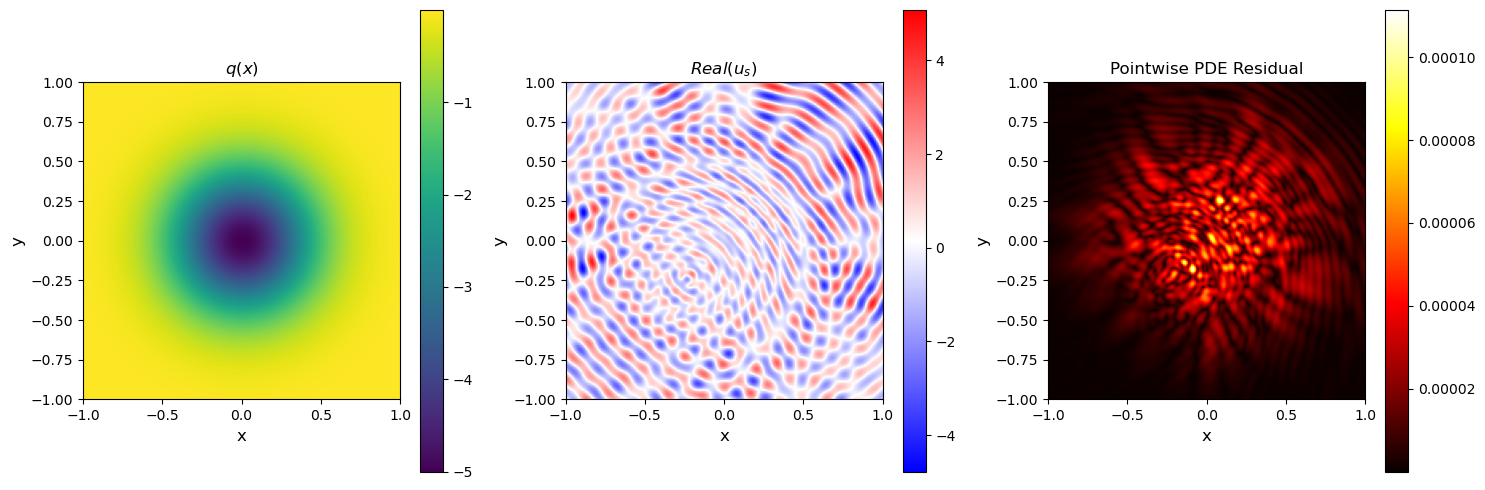

In [47]:
EXTENT = np.array([-1, 1, -1, 1])
S = 12
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

im_0 = ax[0].imshow(q, extent=EXTENT)
ax[0].set_xlabel("x", size=S)
ax[0].set_ylabel("y", size=S)
ax[0].set_title("$q(x)$", size=S)
plt.colorbar(im_0, ax=ax[0])



im_1 = ax[1].imshow(u_scat.real, extent=EXTENT, cmap='bwr')
ax[1].set_xlabel("x", size=S)
ax[1].set_ylabel("y", size=S)
ax[1].set_title("$Real(u_s)$", size=S)
plt.colorbar(im_1, ax=ax[1])

im_2 = ax[2].imshow(np.abs(errs), extent=EXTENT, cmap='hot')
ax[2].set_xlabel("x", size=S)
ax[2].set_ylabel("y", size=S)
ax[2].set_title("Pointwise PDE Residual", size=S)
plt.colorbar(im_2, ax=ax[2])

fig.tight_layout()
plt.show()

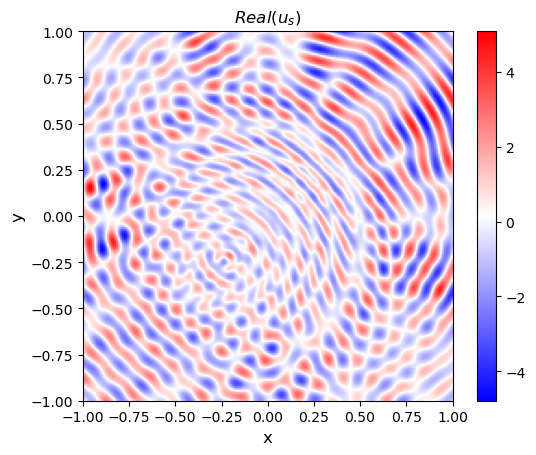

In [48]:
fig, ax = plt.subplots()

im_1 = ax.imshow(u_scat.real, extent=EXTENT, cmap='bwr')
ax.set_xlabel("x", size=S)
ax.set_ylabel("y", size=S)
ax.set_title("$Real(u_s)$", size=S)
plt.colorbar(im_1, ax=ax)
plt.show()